In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2
import sys
sys.path.append("../../")
from src import soporte_sql as s_sql
%load_ext autoreload
%autoreload 2

In [4]:
conn = s_sql.crear_conexion()
query = conn = s_sql.crear_conexion()
cur = conn.cursor()

consulta = """
SELECT 
    dv.model_id, 
    marca, 
    dv.modelo_dgt, 
    dv.año AS año_modelo, 
    dv.combustible, 
    tipo_distintivo,
    catelec, 
    provincia, 
    matriculados, 
    tipo_carroceria, 
    m.año AS año_review, 
    precio_base, 
    precio_max, 
    longitud, 
    volumen_maletero, 
    potencia_minima, 
    potencia_maxima, 
    caja_cambios, 
    tipo_traccion
FROM datos_ventas dv
INNER JOIN id_modelo_dgt imd 
    ON dv.model_id = imd.model_id AND dv.modelo_dgt = imd.modelo_dgt
INNER JOIN modelos m 
    ON imd.model_id = m.model_id
INNER JOIN caracteristicas c 
    ON c.model_id = m.model_id
INNER JOIN impresiones_modelo im 
    ON im.model_id = m.model_id;

   
"""

try:
    cur.execute(consulta)
    resultados = cur.fetchall()  # Obtener los datos
    
    # Obtener los nombres de las columnas automáticamente
    columnas = [desc[0] for desc in cur.description]

    # Crear el DataFrame
    df_resultado = pd.DataFrame(resultados, columns=columnas)
except Exception as e:
    print("Error al ejecutar la consulta:", e)
finally:
    cur.close()
    conn.close()

Error al ejecutar la consulta: no existe la columna m.model_id
LINE 26:     ON imd.model_id = m.model_id
                               ^
HINT:  Probablemente quiera hacer referencia a la columna «dv.model_id» o la columna «imd.model_id».



Ya conocemos los datos pero vamos a normalizar la tabla para poder trabajar mejor con los datos

In [209]:
len(df_resultado.T)

19

In [ ]:
#Expandimos las columnas con listas en el df
df_longitud = pd.DataFrame(df_resultado["longitud"].apply(sorted).to_list(), columns = ["lon_a","mon_b"]).astype(float)
display(df_longitud.dtypes)

df_maletero = pd.DataFrame(df_resultado["volumen_maletero"].apply(sorted).to_list(), columns = ["maletero_a","maletero_b"]).astype(float)
display(df_maletero.dtypes)

df_cambios = df_resultado["caja_cambios"].str.strip("{}").str.split(",").apply(sorted)
df_cambios = df_cambios.to_frame(name="Tipo_cambio")
df_cambios.reset_index(drop=True)
df_cambios = df_cambios.explode("Tipo_cambio")
df_cambios = pd.crosstab(df_cambios.index,df_cambios["Tipo_cambio"])

display(df_cambios.dtypes)

df_tr = (df_resultado["tipo_traccion"].str.split("/").apply(sorted))
df_tr = df_tr.to_frame(name="Traccion")
df_tr.reset_index(drop=True)
df_tr = df_tr.explode("Traccion")
df_tr = pd.crosstab(df_tr.index,df_tr["Traccion"])

display(df_tr.dtypes)


df_res = df_resultado.join(df_longitud)
df_res = df_res.join(df_maletero)
df_res = df_res.join(df_cambios)
df_res = df_res.join(df_tr)

df_res = df_res.drop(columns = ["longitud","volumen_maletero","caja_cambios","tipo_traccion"])


lon_a    float64
Lon_b    float64
dtype: object

maletero_a    float64
Maletero_b    float64
dtype: object

Tipo_cambio
Aut    int64
Man    int64
dtype: object

Traccion
4x4     int64
Del     int64
Tras    int64
dtype: object

In [211]:
df_res

,model_id,marca,modelo_dgt,año_modelo,combustible,tipo_distintivo,catelec,provincia,matriculados,tipo_carroceria,...,potencia_maxima,lon_a,Lon_b,maletero_a,Maletero_b,Aut,Man,4x4,Del,Tras
0,explorer_2024_1,ford,EXPLORER,1999,1.0,SIN DISTINTIVO,NO ELÉCTRICO,3,1,estandar,...,340,4.47,NaN,470.0,NaN,1,0,1,0,1
1,explorer_2024_1,ford,EXPLORER,1999,1.0,SIN DISTINTIVO,NO ELÉCTRICO,13,2,estandar,...,340,4.47,NaN,470.0,NaN,1,0,1,0,1
2,explorer_2024_1,ford,EXPLORER,1999,1.0,SIN DISTINTIVO,NO ELÉCTRICO,17,1,estandar,...,340,4.47,NaN,470.0,NaN,1,0,1,0,1
3,explorer_2024_1,ford,EXPLORER,1999,1.0,SIN DISTINTIVO,NO ELÉCTRICO,19,1,estandar,...,340,4.47,NaN,470.0,NaN,1,0,1,0,1
4,explorer_2024_1,ford,EXPLORER,1999,1.0,SIN DISTINTIVO,NO ELÉCTRICO,28,7,estandar,...,340,4.47,NaN,470.0,NaN,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111890,mx-30_2020_4,mazda,MX 30,2023,1.0,CERO,PHEV,8,9,estandar,...,170,4.40,NaN,332.0,350.0,1,0,0,1,0
111891,mx-30_2020_4,mazda,MX 30,2023,1.0,CERO,PHEV,28,26,estandar,...,170,4.40,NaN,332.0,350.0,1,0,0,1,0
111892,mx-30_2020_4,mazda,MX 30,2023,1.0,CERO,PHEV,30,3,estandar,...,170,4.40,NaN,332.0,350.0,1,0,0,1,0
111893,mx-30_2020_4,mazda,MX 30,2023,1.0,CERO,PHEV,45,1,estandar,...,170,4.40,NaN,332.0,350.0,1,0,0,1,0


In [212]:
df_tr

Traccion,4x4,Del,Tras
row_0,,,
0,1,0,1
1,1,0,1
2,1,0,1
3,1,0,1
4,1,0,1
...,...,...,...
111890,0,1,0
111891,0,1,0
111892,0,1,0


In [213]:
len(df_res)

111895

In [214]:
df_res.sample()

,model_id,marca,modelo_dgt,año_modelo,combustible,tipo_distintivo,catelec,provincia,matriculados,tipo_carroceria,...,potencia_maxima,lon_a,Lon_b,maletero_a,Maletero_b,Aut,Man,4x4,Del,Tras
110508,juke_2024_3,nissan,JUKE,2019,1.0,DISTINTIVO C,NO ELÉCTRICO,24,20,estandar,...,143,4.21,NaN,354.0,422.0,1,1,0,1,0


In [215]:
print(df_res.dtypes)

df_res["combustible"] = df_res["combustible"].astype(float)
df_res["provincia"] = df_res["provincia"].astype(int)
df_res["precio_base"] = df_res["precio_base"].astype(float)
df_res["precio_max"] = df_res["precio_max"].astype(float)
df_res["potencia_minima"] = df_res["potencia_minima"].astype(int)
df_res["potencia_maxima"] = df_res["potencia_maxima"].astype(int)


model_id            object
marca               object
modelo_dgt          object
año_modelo           int64
combustible         object
tipo_distintivo     object
catelec             object
provincia           object
matriculados         int64
tipo_carroceria     object
año_review           int64
precio_base         object
precio_max          object
potencia_minima     object
potencia_maxima     object
lon_a              float64
Lon_b              float64
maletero_a         float64
Maletero_b         float64
Aut                  int64
Man                  int64
4x4                  int64
Del                  int64
Tras                 int64
dtype: object


## Ahora que tenemos el Df limpio vamos a realizar un EDA. 

Empezamos con las variables numéricas:

In [216]:
provincia_ccaa_dict = {
    1: "País Vasco",  # Araba/Álava
    2: "Castilla-La Mancha",  # Albacete
    3: "Comunidad Valenciana",  # Alicante/Alacant
    4: "Andalucía",  # Almería
    5: "Castilla-La Mancha",  # Ávila
    6: "Extremadura",  # Badajoz
    7: "Islas Baleares",  # Balears (Illes)
    8: "Cataluña",  # Barcelona
    9: "Castilla y León",  # Burgos
    10: "Extremadura",  # Cáceres
    11: "Andalucía",  # Cádiz
    12: "Comunidad Valenciana",  # Castellón/Castelló
    13: "Castilla-La Mancha",  # Ciudad Real
    14: "Andalucía",  # Córdoba
    15: "Galicia",  # Coruña (A)
    16: "Castilla-La Mancha",  # Cuenca
    17: "Cataluña",  # Girona
    18: "Andalucía",  # Granada
    19: "Castilla-La Mancha",  # Guadalajara
    20: "País Vasco",  # Gipuzkoa
    21: "Andalucía",  # Huelva
    22: "Aragón",  # Huesca
    23: "Andalucía",  # Jaén
    24: "Castilla y León",  # León
    25: "Cataluña",  # Lleida
    26: "La Rioja",  # Rioja (La)
    27: "Galicia",  # Lugo
    28: "Madrid",  # Madrid
    29: "Andalucía",  # Málaga
    30: "Murcia",  # Murcia
    31: "Navarra",  # Navarra
    32: "Galicia",  # Ourense
    33: "Asturias",  # Asturias
    34: "Castilla y León",  # Palencia
    35: "Canarias",  # Palmas (Las)
    36: "Galicia",  # Pontevedra
    37: "Castilla y León",  # Salamanca
    38: "Canarias",  # Santa Cruz de Tenerife
    39: "Cantabria",  # Cantabria
    40: "Castilla y León",  # Segovia
    41: "Andalucía",  # Sevilla
    42: "Castilla y León",  # Soria
    43: "Cataluña",  # Tarragona
    44: "Aragón",  # Teruel
    45: "Castilla-La Mancha",  # Toledo
    46: "Comunidad Valenciana",  # Valencia/València
    47: "Castilla y León",  # Valladolid
    48: "País Vasco",  # Bizkaia
    49: "Castilla y León",  # Zamora
    50: "Aragón",  # Zaragoza
    51: "Ceuta",  # Ceuta
    52: "Melilla",  # Melilla
    99: "Extranjero",  # Extranjero
    100: "Desconocido"  # Desconocido
}


In [217]:
df_num= df_res.select_dtypes(np.number)
df_num = df_num.join(df_res["modelo_dgt"])
df_num.head()

,año_modelo,combustible,provincia,matriculados,año_review,precio_base,precio_max,potencia_minima,potencia_maxima,lon_a,Lon_b,maletero_a,Maletero_b,Aut,Man,4x4,Del,Tras,modelo_dgt
0,1999,1.0,3,1,2024,41812.0,58871.0,170,340,4.47,NaN,470.0,NaN,1,0,1,0,1,EXPLORER
1,1999,1.0,13,2,2024,41812.0,58871.0,170,340,4.47,NaN,470.0,NaN,1,0,1,0,1,EXPLORER
2,1999,1.0,17,1,2024,41812.0,58871.0,170,340,4.47,NaN,470.0,NaN,1,0,1,0,1,EXPLORER
3,1999,1.0,19,1,2024,41812.0,58871.0,170,340,4.47,NaN,470.0,NaN,1,0,1,0,1,EXPLORER
4,1999,1.0,28,7,2024,41812.0,58871.0,170,340,4.47,NaN,470.0,NaN,1,0,1,0,1,EXPLORER


Vamos a asignarle el id de modelo al df numérico y vamos a emprender el EDA en dos ramas de investigación: 
- Distribución de las variables numéricas para ver sesgos
- Análisis por año de las ventas

Posteriormente trataremos los datos:

- Gestión de valores nulos
- Gestión de outliers
- Codificación
- Estandarización

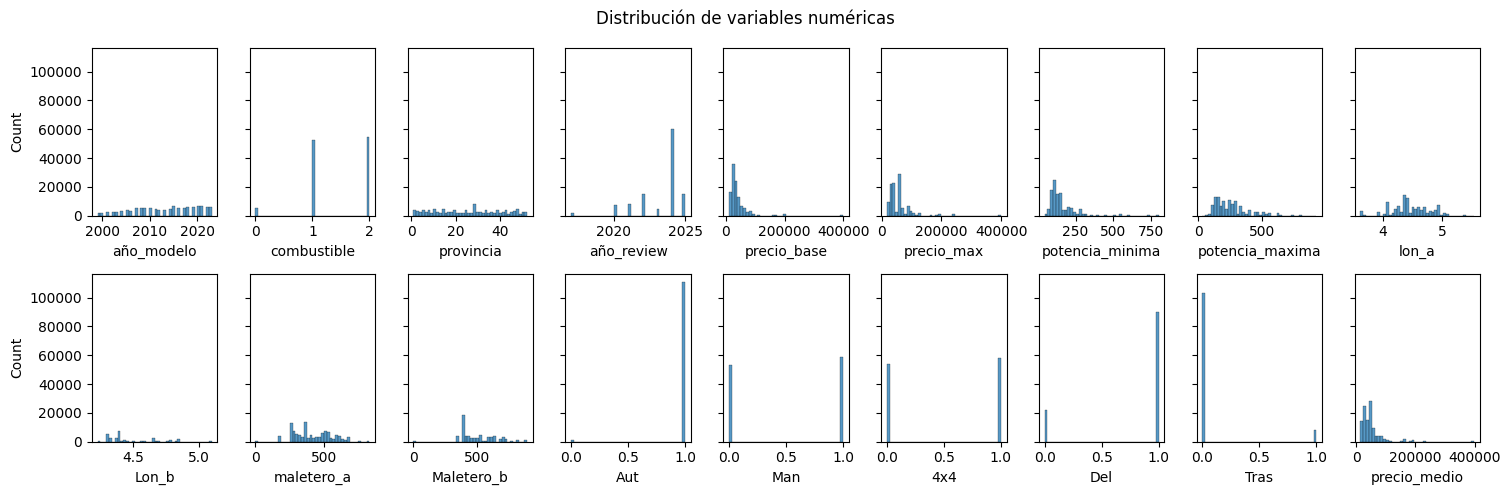

In [218]:
# Vamos a ver cómo se distribuyen los precios. Para ello vamos a establecer la media entre precios minimos y maximos

df_num["precio_medio"] = df_num[["precio_base","precio_max"]].mean(axis = 1)

visual_num = s_eda.Visualizador(df_num.drop(columns = ["matriculados","modelo_dgt"]))
visual_num.plot_numericas()

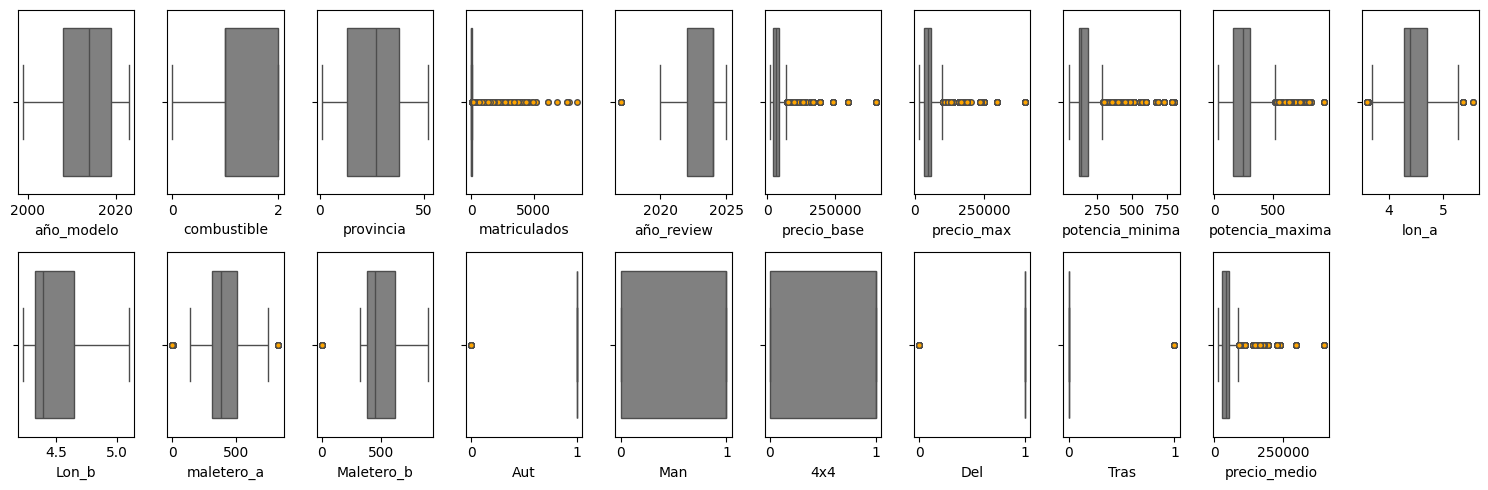

In [219]:
visual_num = s_eda.Visualizador(df_num.drop(columns = "modelo_dgt"))
visual_num.deteccion_outliers()

In [220]:
df_num["CCAA"] = df_num["provincia"].replace(provincia_ccaa_dict)
df_num.head()

,año_modelo,combustible,provincia,matriculados,año_review,precio_base,precio_max,potencia_minima,potencia_maxima,lon_a,...,maletero_a,Maletero_b,Aut,Man,4x4,Del,Tras,modelo_dgt,precio_medio,CCAA
0,1999,1.0,3,1,2024,41812.0,58871.0,170,340,4.47,...,470.0,NaN,1,0,1,0,1,EXPLORER,50341.5,Comunidad Valenciana
1,1999,1.0,13,2,2024,41812.0,58871.0,170,340,4.47,...,470.0,NaN,1,0,1,0,1,EXPLORER,50341.5,Castilla-La Mancha
2,1999,1.0,17,1,2024,41812.0,58871.0,170,340,4.47,...,470.0,NaN,1,0,1,0,1,EXPLORER,50341.5,Cataluña
3,1999,1.0,19,1,2024,41812.0,58871.0,170,340,4.47,...,470.0,NaN,1,0,1,0,1,EXPLORER,50341.5,Castilla-La Mancha
4,1999,1.0,28,7,2024,41812.0,58871.0,170,340,4.47,...,470.0,NaN,1,0,1,0,1,EXPLORER,50341.5,Madrid


In [221]:
df_res["CCAA"] = df_res["provincia"].replace(provincia_ccaa_dict)
df_res_ccaa = df_res.groupby(["CCAA","año_modelo","catelec"])["matriculados"].size().reset_index()

In [222]:
df_res_ccaa.head()

,CCAA,año_modelo,catelec,matriculados
0,Andalucía,1999,NO ELÉCTRICO,262
1,Andalucía,2000,NO ELÉCTRICO,357
2,Andalucía,2001,NO ELÉCTRICO,371
3,Andalucía,2002,NO ELÉCTRICO,428
4,Andalucía,2003,NO ELÉCTRICO,397


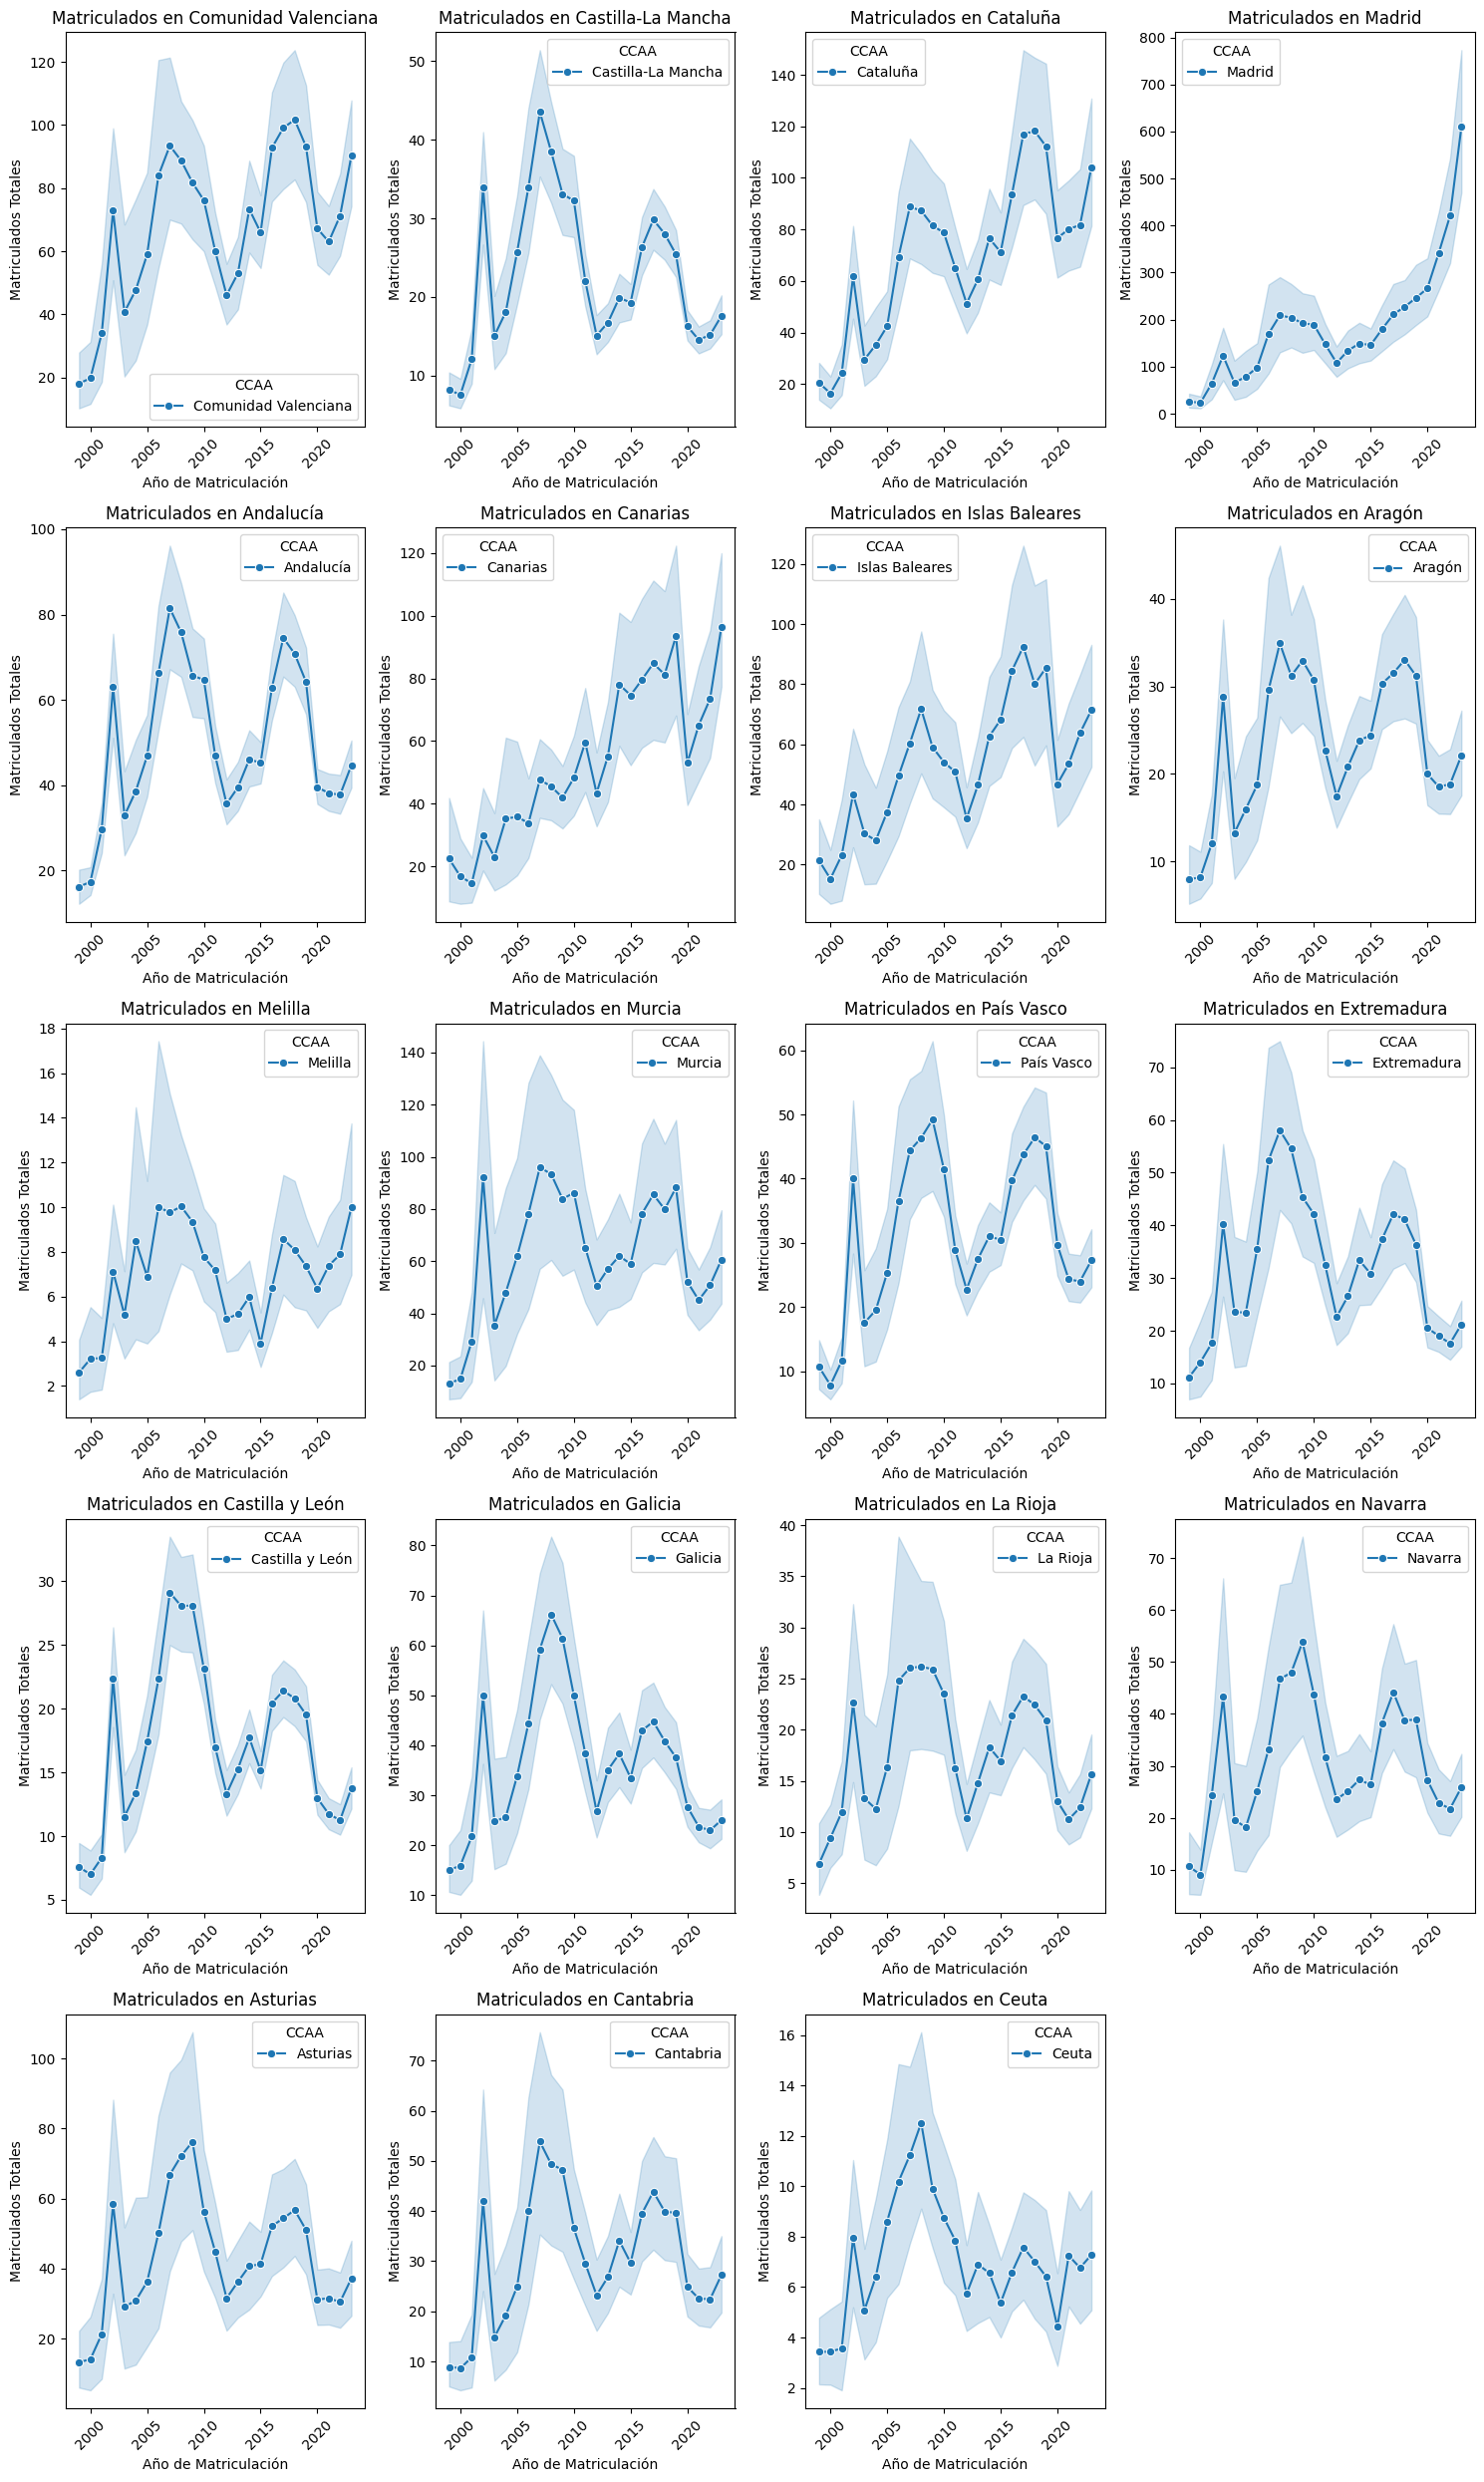

In [223]:
# Crear subplots por cada CCAA
unique_ccaa = df_num['CCAA'].unique()

# Establecer el número de filas y columnas de subplots
n_cols = 4
n_rows = (len(unique_ccaa) // n_cols) + (1 if len(unique_ccaa) % n_cols != 0 else 0)

plt.figure(figsize=(15, 5 * n_rows))

# Graficar por CCAA
for idx, ccaa in enumerate(unique_ccaa):
    plt.subplot(n_rows, n_cols, idx + 1)
    df_ccaa = df_num[df_num['CCAA'] == ccaa]  # Filtrar el DataFrame por CCAA
    sns.lineplot(data=df_ccaa, x='año_modelo', y='matriculados', hue='CCAA', marker='o')
    plt.title(f'Matriculados en {ccaa}')
    plt.xlabel('Año de Matriculación')
    plt.ylabel('Matriculados Totales')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


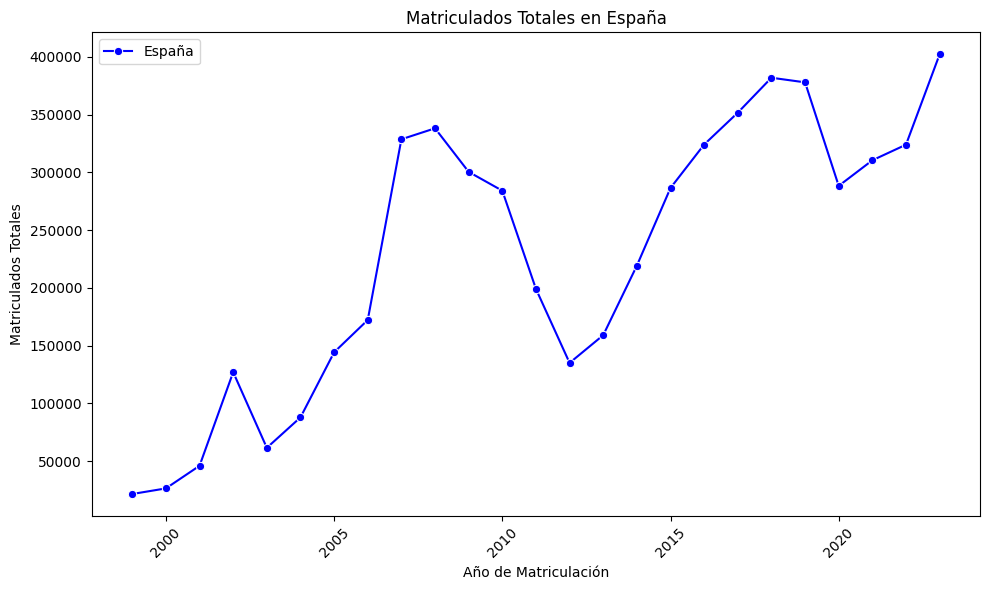

In [224]:
#Matriculados totales en españa
df_total_espana = df_num.groupby('año_modelo')['matriculados'].sum().reset_index()
# Graficar solo para España
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_total_espana, x='año_modelo', y='matriculados', label='España', color='blue', marker='o')

plt.title('Matriculados Totales en España')
plt.xlabel('Año de Matriculación')
plt.ylabel('Matriculados Totales')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

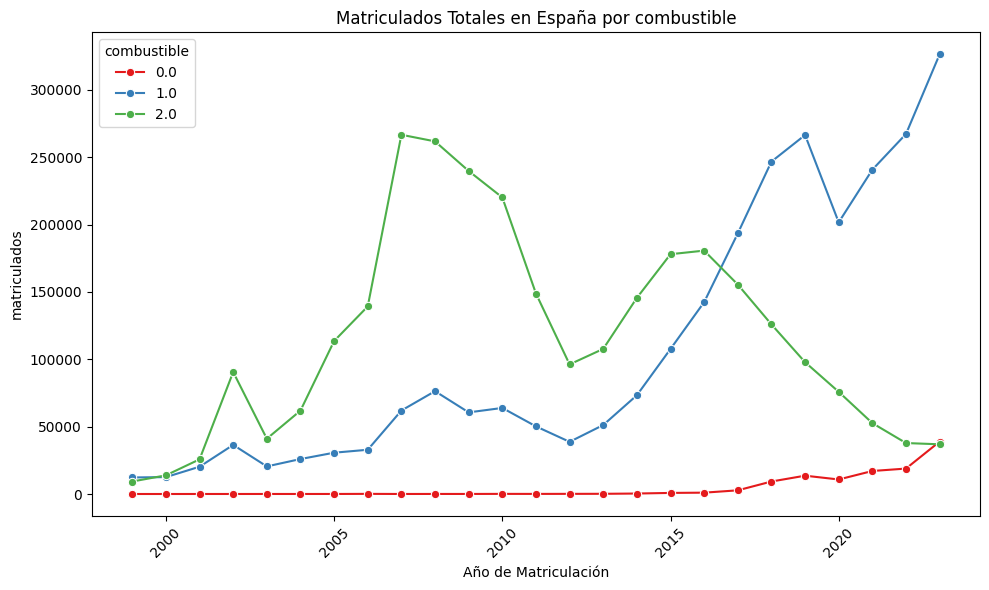

In [225]:
# Matriculados por combustible
df_total_espana = df_res.groupby(['año_modelo',"combustible"])['matriculados'].sum().reset_index()
# Graficar solo para España
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_total_espana, x='año_modelo', y='matriculados', color='blue', marker='o', hue = "combustible", palette = "Set1")

plt.title('Matriculados Totales en España por combustible')
plt.xlabel('Año de Matriculación')
# plt.ylabel('Matriculados Totales')
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

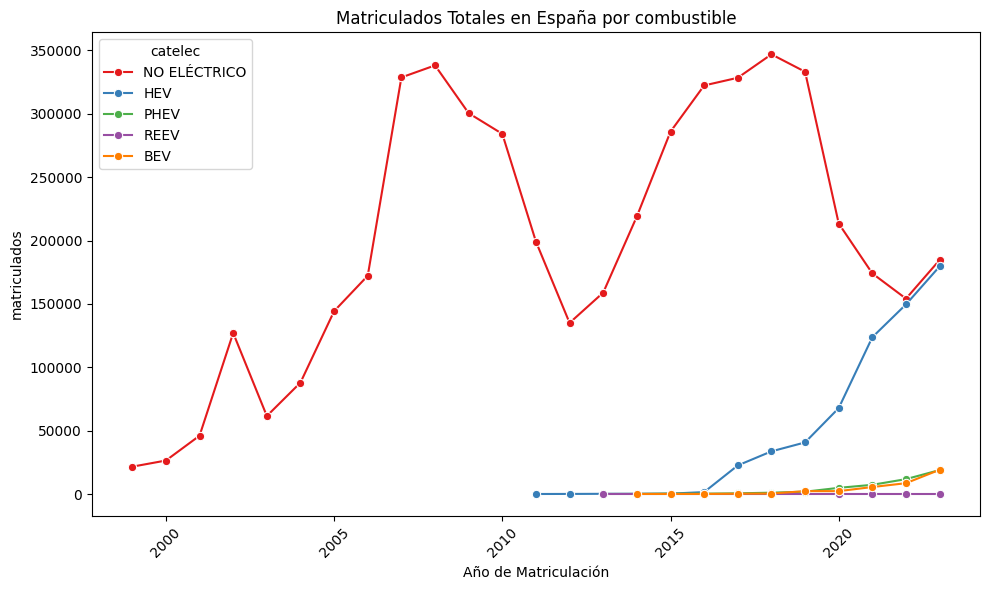

In [226]:
# Matriculados por categoría electrica

# Matriculados por combustible
df_total_espana = df_res.groupby(['año_modelo',"catelec"])['matriculados'].sum().reset_index()
# Graficar solo para España
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_total_espana, x='año_modelo', y='matriculados', color='blue', marker='o', hue = "catelec", palette = "Set1")

plt.title('Matriculados Totales en España por combustible')
plt.xlabel('Año de Matriculación')
# plt.ylabel('Matriculados Totales')
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

In [227]:
df_res.to_csv("../../CSV/Bdd_coches.csv")